In [2]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-dark-palette")  # seaborn style
plt.rcParams.update(
    {
        "figure.figsize": (12, 6),  # set default figure size
        "axes.labelsize": 16,  # set default label size
        "axes.grid": True,  # enable grid by default
        
        "xtick.labelsize": 14,  # set default tick label size
        "ytick.labelsize": 14,  # set default tick label size
        "axes.titlesize": 18,  # set default title size
        "legend.fontsize": 16,  # set default legend font size
        "lines.linewidth": 4,  # set default line width
        "text.usetex": False,  # use LaTeX
        "font.family": "serif",  # use a serif font
    }
)

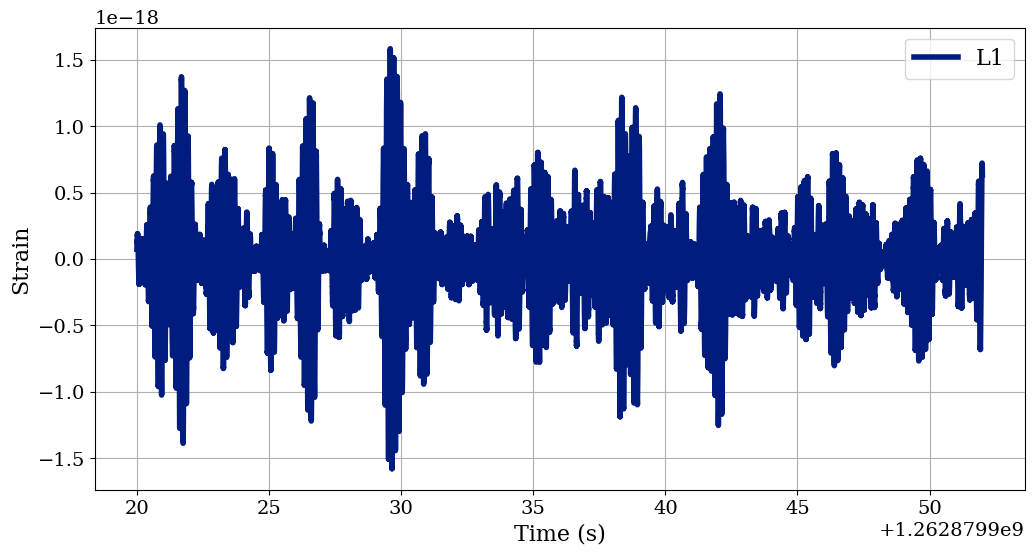

In [3]:

from pycbc import catalog
m = catalog.Merger("GW200112_155838-v1", source='gwtc-3')

ts_liv = m.strain('L1')

plt.plot(ts_liv.sample_times, ts_liv, label="L1")
plt.legend()
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.show()

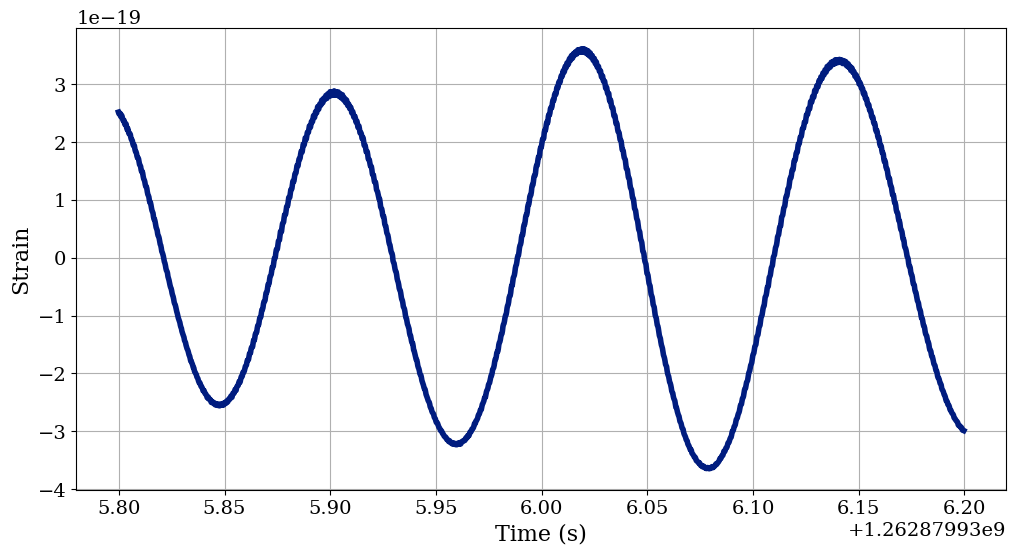

In [4]:
merge_window = ts_liv.time_slice(m.time - 0.2, m.time + 0.2 )
plt.plot(merge_window.sample_times, merge_window)
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.show()

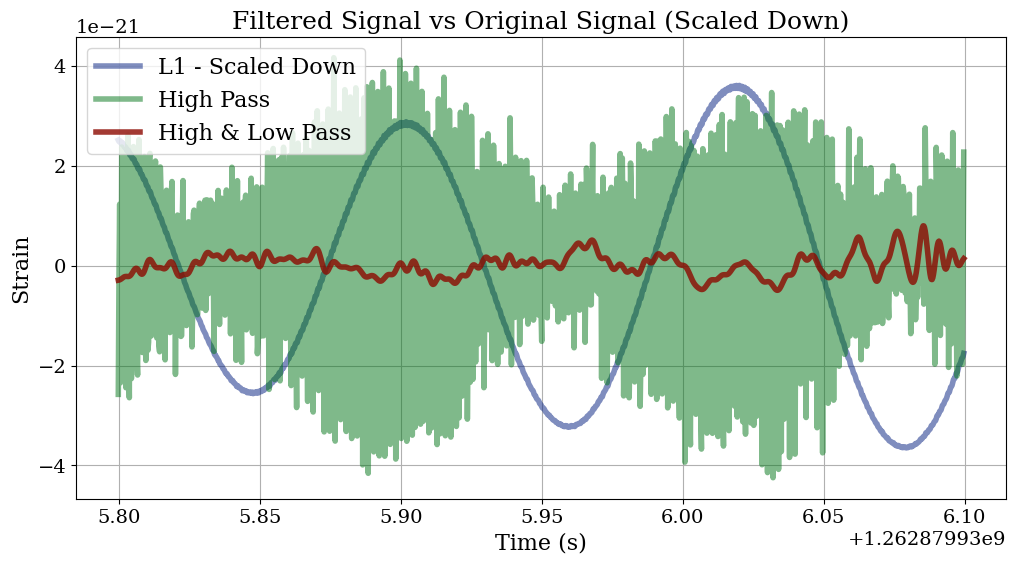

In [5]:

highpass = ts_liv.highpass_fir(30, 512)
lowpass = highpass.lowpass_fir(250, 512) # two more freq filters


# zoom in on event
event = lowpass.time_slice(m.time -0.2, m.time + 0.1)
plt.plot(event.sample_times, ts_liv.time_slice(m.time -0.2, m.time + 0.1) / 100, label="L1 - Scaled Down", alpha=0.5)
plt.plot(event.sample_times, highpass.time_slice(m.time -0.2, m.time + 0.1), label="High Pass", alpha=0.5)
plt.plot(event.sample_times, event, label="High & Low Pass", alpha=0.8)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Filtered Signal vs Original Signal (Scaled Down)')
plt.legend()
plt.show()

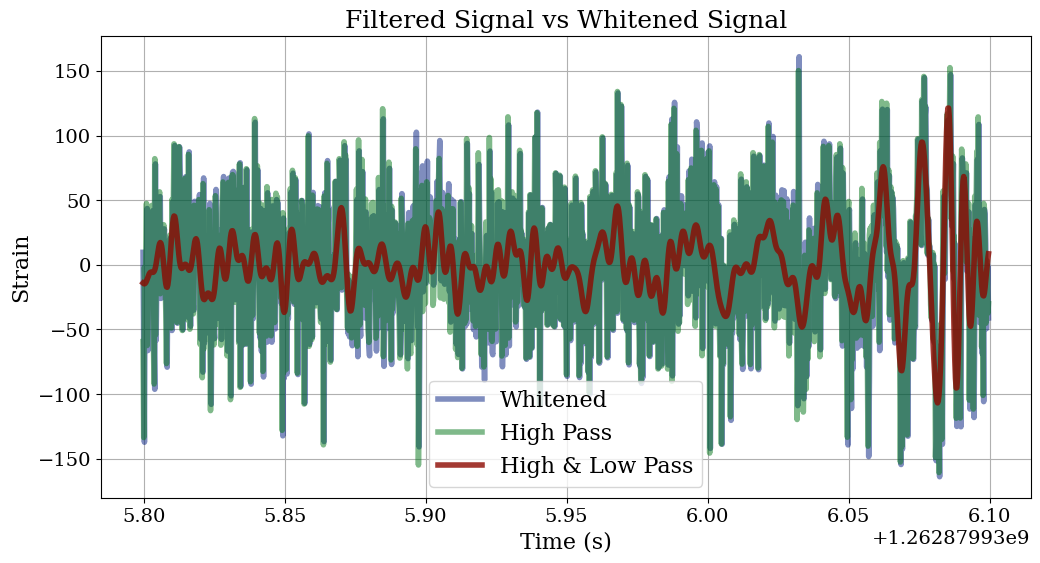

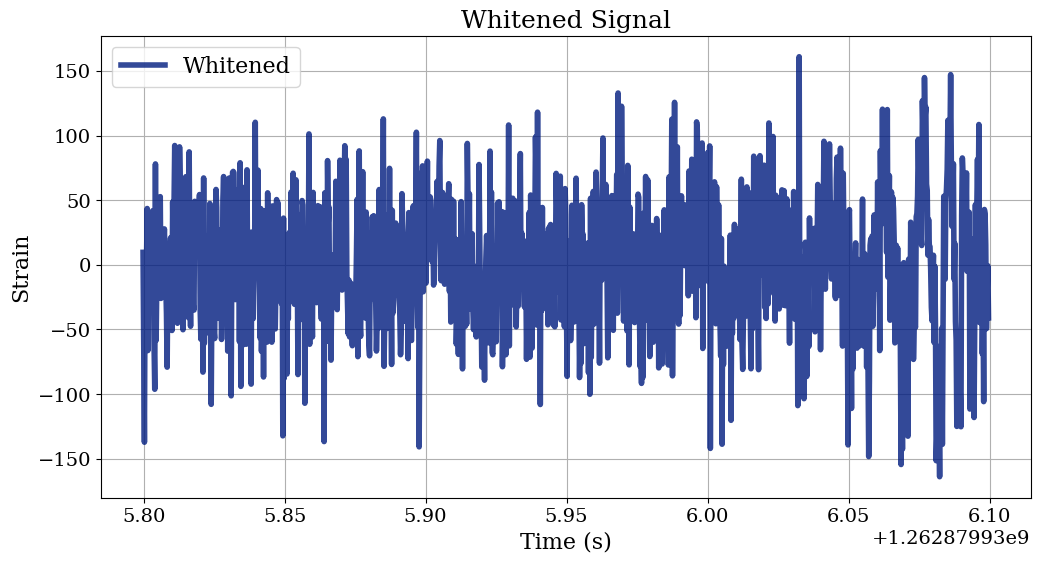

In [6]:
whitened = ts_liv.whiten(4, 4) # Flatten Freq Response of PSD
highpass = whitened.highpass_fir(30, 512)
lowpass = highpass.lowpass_fir(250, 512) # two more freq filters


# zoom in on event
event = lowpass.time_slice(m.time -0.2, m.time + 0.1)
plt.plot(event.sample_times, whitened.time_slice(m.time -0.2, m.time + 0.1), label="Whitened", alpha=0.5)
plt.plot(event.sample_times, highpass.time_slice(m.time -0.2, m.time + 0.1), label="High Pass", alpha=0.5)
plt.plot(event.sample_times, event, label="High & Low Pass", alpha=0.8)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Filtered Signal vs Whitened Signal')
plt.legend()
plt.show()

# just whitened
event = whitened.time_slice(m.time -0.2, m.time + 0.1)
plt.plot(event.sample_times, event, label="Whitened", alpha=0.8)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Whitened Signal')
plt.legend()
plt.show()

Output()

Running 400 trials...


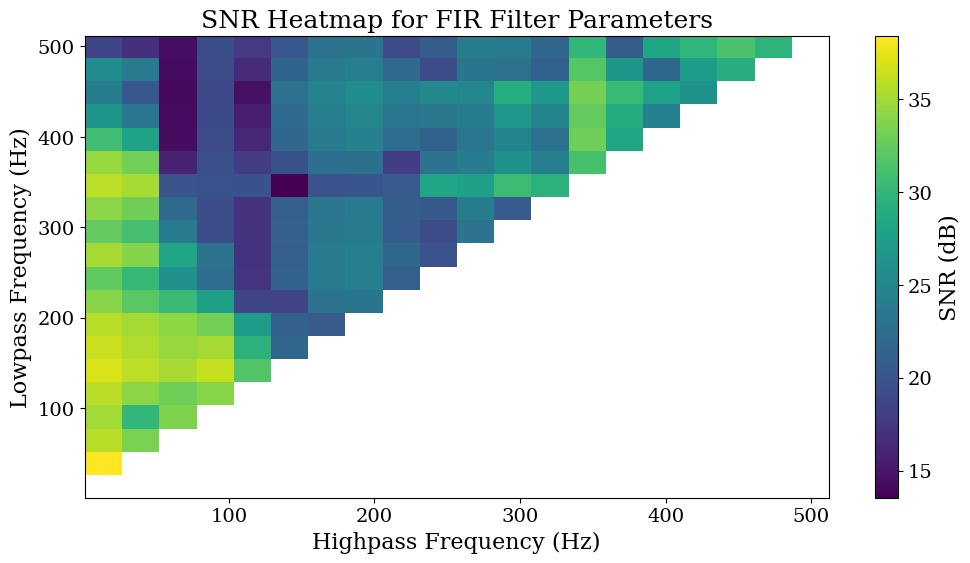

In [7]:
import numpy as np
from rich.progress import track
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
from functools import lru_cache
from pycbc.types import TimeSeries, FrequencySeries


def fir_filter(signal, lowpass, highpass):
    """Applies FIR highpass and lowpass filters to the input signal."""
     
    @lru_cache(maxsize=None) # Cache results for performance
    def highpass_fir(cutoff):
        return signal.highpass_fir(cutoff, 1024)
    
    filtered_signal = highpass_fir(highpass)
    filtered_signal = filtered_signal.lowpass_fir(lowpass, 1024)
    
    # Ensure filtered signal is cropped to valid time range after filtering
    # FIR filters may shift the valid time range, so we use the filtered signal's own time range
    valid_start = max(signal.start_time, filtered_signal.start_time)
    valid_end = min(signal.end_time, filtered_signal.end_time)
    filtered_signal = filtered_signal.time_slice(valid_start, valid_end)
    return filtered_signal

def snr(raw_signal, filtered_signal):
    """Calculates the signal-to-noise ratio (SNR) between the raw and filtered signals."""
    # Ensure both signals are aligned in time
    raw_signal = raw_signal.time_slice(filtered_signal.start_time, filtered_signal.end_time)
    noise = raw_signal - filtered_signal 
    signal_power = np.asarray(filtered_signal ** 2).mean()
    noise_power = np.asarray(noise ** 2).mean()
    return 10 * np.log10(signal_power / noise_power)

def snr_template(filtered_signal: TimeSeries):
    """Calculates the SNR of the filtered signal against a given template."""
    psd = filtered_signal.filter_psd(0.125, filtered_signal.delta_f, flow=20)
    template, _ = get_fd_waveform(approximant="IMRPhenomD", mass1=m.mass1, mass2=m.mass2,
                              delta_f=filtered_signal.delta_f, f_lower=20, f_final=2048)
    # Cut off last frequency for template and psd to match lengths
    template = template[:len(filtered_signal)]
    psd = psd[:len(filtered_signal)]
    snr = matched_filter(template, filtered_signal, psd=psd, low_frequency_cutoff=20)
    peak = abs(snr).max()
    return 10 * np.log10(peak)

f_range = np.linspace(1, 512, 20)
snr_results = np.zeros((len(f_range), len(f_range)))
whitened = ts_liv.whiten(4, 4).time_slice(m.time - 1, m.time + 1) # Flatten Freq Response of PSD

USE_TEMPLATE_SNR = True


def trial(band): 
    """Runs a trial of FIR filtering and SNR calculation."""
    lowpass, highpass = band
    
    if highpass >= lowpass:
        return -np.inf  # Invalid filter parameters
    
    filtered_signal = fir_filter(whitened, lowpass, highpass)
    if USE_TEMPLATE_SNR:
        return snr_template(filtered_signal)
    else:
        return snr(whitened, filtered_signal)

bands = [(lp, hp) for lp in f_range for hp in f_range]

print(f"Running {len(bands)} trials...")

results = [trial(band) for band in track(bands)]
snr_results = np.array(results).reshape(len(f_range), len(f_range))
plt.imshow(snr_results, extent=(f_range.min(), f_range.max(), f_range.min(), f_range.max()), origin='lower', aspect='auto')
plt.grid(False)
plt.colorbar(label='SNR (dB)')
plt.xlabel('Highpass Frequency (Hz)')
plt.ylabel('Lowpass Frequency (Hz)')
plt.title('SNR Heatmap for FIR Filter Parameters')
plt.show()



ValueError: x and y must have same first dimension, but have shapes (1229,) and (65536,)

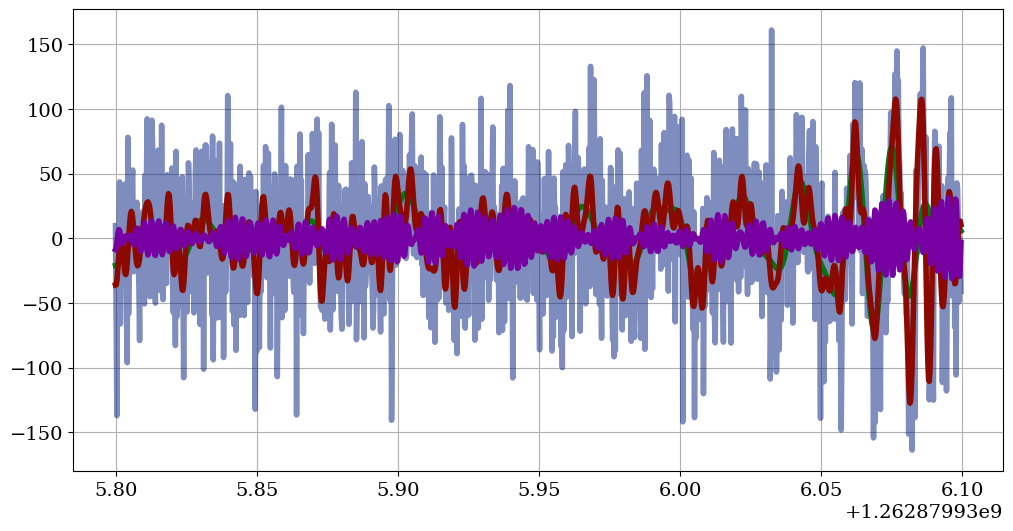

In [ ]:
from pycbc.waveform import get_td_waveform
event = whitened.time_slice(m.time -0.2, m.time + 0.1)
plt.plot(event.sample_times, event, label="whitened", alpha=0.5)
plt.plot(event.sample_times, fir_filter(whitened, 100, 15).time_slice(m.time -0.2, m.time + 0.1), label="100 Hz Lowpass, 15 Hz Highpass")
plt.plot(event.sample_times, fir_filter(whitened, 350, 15).time_slice(m.time -0.2, m.time + 0.1), label="350 Hz Lowpass, 15 Hz Highpass")
plt.plot(event.sample_times, fir_filter(whitened, 450, 350).time_slice(m.time -0.2, m.time + 0.1), label="450 Hz Lowpass, 350 Hz Highpass")
template = get_td_waveform(approximant="IMRPhenomD", mass1=m.mass1, mass2=m.mass2,
                              delta_t=whitened.delta_t, f_lower=20)[0]
template.start_time = m.time - template.duration

plt.plot(event.sample_times, template, label="Template", alpha=0.8)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('FIR Filtered Signals with Different Cutoffs')
plt.legend()
plt.show()
